In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import lmpsetup
import hmdsetup

import lmp
import hmd

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import analysis

import scipy.constants as cnt

import shutil
import os
import mdtraj as md
import statsmodels.tsa.stattools
import MDAnalysis.analysis as mda
import scipy
from matplotlib.lines import Line2D
import matplotlib

from style_vars import *
plt.style.use('default')
# plt.style.use('style.mplstyle')

hps_lines = [Line2D([0], [0], color='black', ls='--'),
                Line2D([0], [0], color='black')]

wt_d4_lines = [Line2D([0], [0], color=C_W),
                Line2D([0], [0], color=C_4)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
d4_rg_th = 47.099186121772135
wt_rg_th = 47.52543178832431
crit_rg = (d4_rg_th+wt_rg_th)/2

### FULL ROUTINE

### 12D - D4

3.643
1.495
0.57
2.166


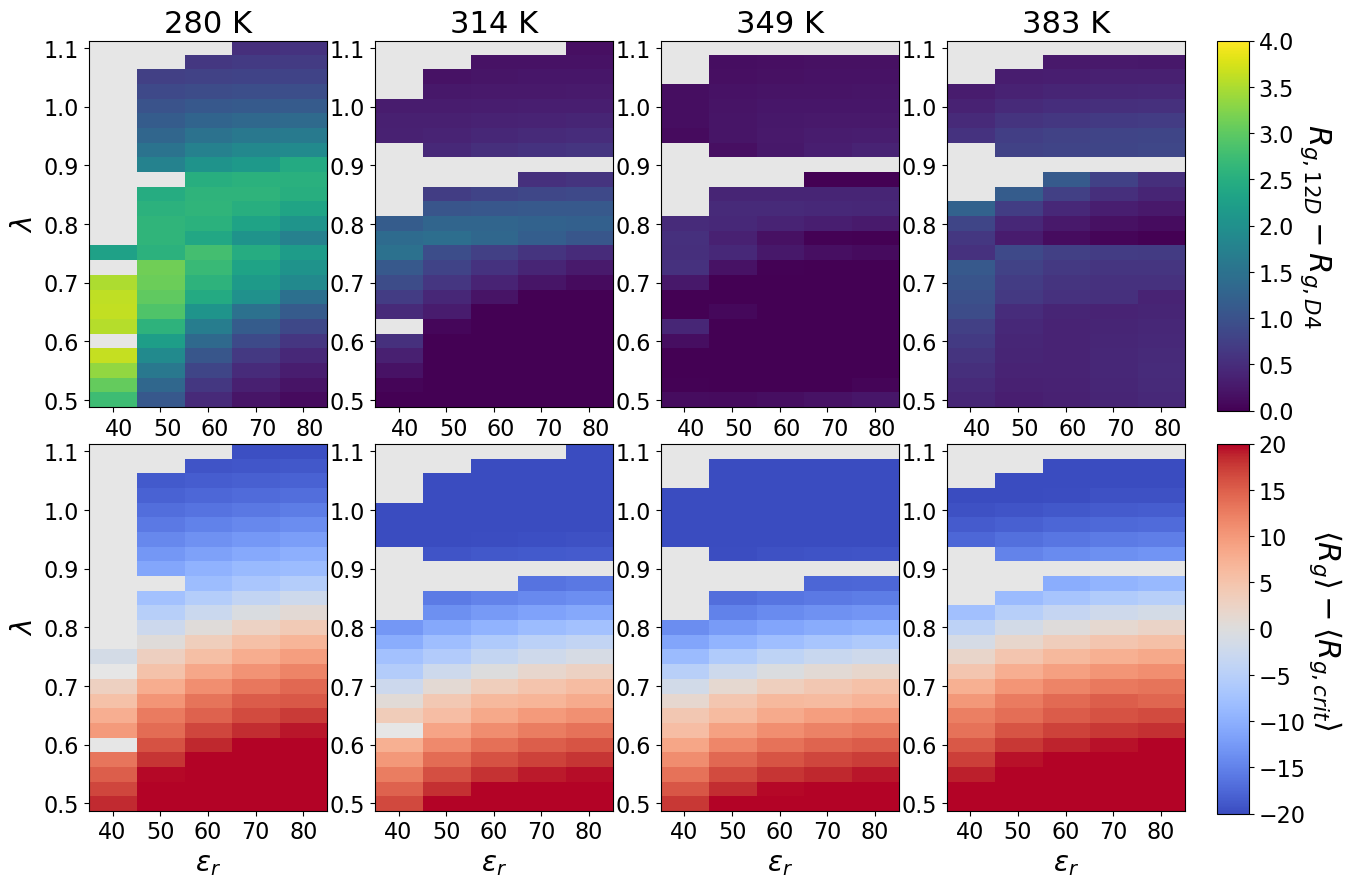

In [123]:
ts = np.linspace(280,400,8)
fig, axs = plt.subplots(2, 4, figsize=(16, 10))

for c, T in enumerate([0,2,4,6]):
    ls=["1.0", "0.8", "0.75", "0.6"]
    data = []
    for l in ls:
        if len(data) == 0:
            data = np.genfromtxt(f'/home/adria/scripts/md/bin/d12-d4/rw_{l}_HPST-{T}.txt', skip_header=2)
        else:
            test = np.genfromtxt(f'/home/adria/scripts/md/bin/d12-d4/rw_{l}_HPST-{T}.txt', skip_header=2)
            data = np.concatenate([data, test])

    ls = np.flip(np.unique(data[:,0]))
    eps = np.flip(np.unique(data[:,1]))
    
    rw = pd.DataFrame(index=eps, columns=ls)
    rw = rw.astype('float64')
    rgf = pd.DataFrame(index=eps, columns=ls)
    rgf = rw.astype('float64')
    neff_rw = pd.DataFrame(np.random.randint(0,10,size=(len(eps), len(ls))), index=eps, columns=ls)
    neff_rw = neff_rw.astype('float64')

    for row in data:
        l = row[0]
        e = row[1]
        diff = row[2]
        neff = row[3]
        neff = row[4]
        rgfr = (row[-1]+row[-2])/2-d4_rg_th
        if not np.isnan(rw[l][e]):
            if neff > neff_rw[l][e]:
                rw[l][e] = diff.astype(float)
                neff_rw[l][e] = neff 
                rgf[l][e] = rgfr
        else:
            rw[l][e] = diff.astype(float)
            neff_rw[l][e] = neff 
            rgf[l][e] = rgfr
    print(rw.values.max())
    cut = 0.1
    mask = rw
    mask.values[np.where(neff_rw.values<cut)] = np.nan
    
    mask2 = rgf
    mask2.values[np.where(neff_rw.values<cut)] = np.nan
    
    cmap = plt.get_cmap()
    cmap.set_bad(color = 'black', alpha = 0.1)
    
    centers = [eps.max(),eps.min(),ls.min(),ls.max()]
    dx, = np.diff(centers[:2])/(rw.T.values.shape[1]-1)
    dy, = -np.diff(centers[2:])/(rw.T.values.shape[0]-1) 
    extent = [centers[0]-dx/2, centers[1]+dx/2, centers[2]+dy/2, centers[3]-dy/2]

#     img_d = axs[0][c].pcolormesh(eps,ls,rw.T, cmap=cmap)
    img_d = axs[0][c].imshow(rw.T, cmap=cmap, aspect='auto', interpolation=None, extent=extent, vmin=0, vmax=4)
    axs[0][c].set_title(f"{ts[T]:.0f} K", fontsize=22)
    axs[0][c].tick_params(axis='both', which='major', labelsize=16)
    axs[0][c].invert_xaxis()
    axs[0][c].set_xticks(eps)
#     dx, = np.diff(centers[:2])/(X.shape[1]-1)
#     dy, = -np.diff(centers[2:])/(X.shape[0]-1)
    for label in axs[0][c].xaxis.get_majorticklabels():
        dx = 5/72.; dy = 0/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        label.set_transform(label.get_transform() + offset)
#     axs[0][c].set_yticks(ls[::2])
    
    cmap = plt.get_cmap('coolwarm')
    cmap.set_bad(color = 'black', alpha = 0.1)
#     img_c = axs[1][c].pcolormesh(eps,ls,rgf.T, cmap=cmap, vmin=-20, vmax=20)
    img_c = axs[1][c].imshow(rgf.T, cmap=cmap, aspect='auto', interpolation=None,  vmin=-20, vmax=20,  extent=extent)
    axs[1][c].set_xlabel("$\epsilon_r$", fontsize=20)
    axs[1][c].tick_params(axis='both', which='major', labelsize=16)
    axs[1][c].invert_xaxis()
    axs[1][c].set_xticks(eps)
#     axs[1][c].set_yticks(ls[::2])
axs[0][0].set_ylabel("$\lambda$", fontsize=20)  
axs[1][0].set_ylabel("$\lambda$", fontsize=20) 

fig.subplots_adjust(right=0.81)
cbar_ax = fig.add_axes([0.83, 0.51, 0.02, 0.37])
cbar1 = fig.colorbar(img_d, cax=cbar_ax)
cbar1.ax.tick_params(labelsize=16)
cbar1.set_label('$R_{g,12D}-R_{g,D4}$', rotation=270, fontsize=22, labelpad=28)


fig.subplots_adjust(right=0.81)
cbar_ax = fig.add_axes([0.83, 0.107, 0.02, 0.37])
cbar2 = fig.colorbar(img_c, cax=cbar_ax)
cbar2.ax.tick_params(labelsize=16)
cbar2.set_label('$\langle R_g⟩ - \langle R_{g,crit}⟩$', rotation=270, fontsize=22, labelpad=28)

fig.subplots_adjust(hspace=0.1)
# fig.tight_layout()

### 7D - WT

2.692
1.347
0.607
1.18


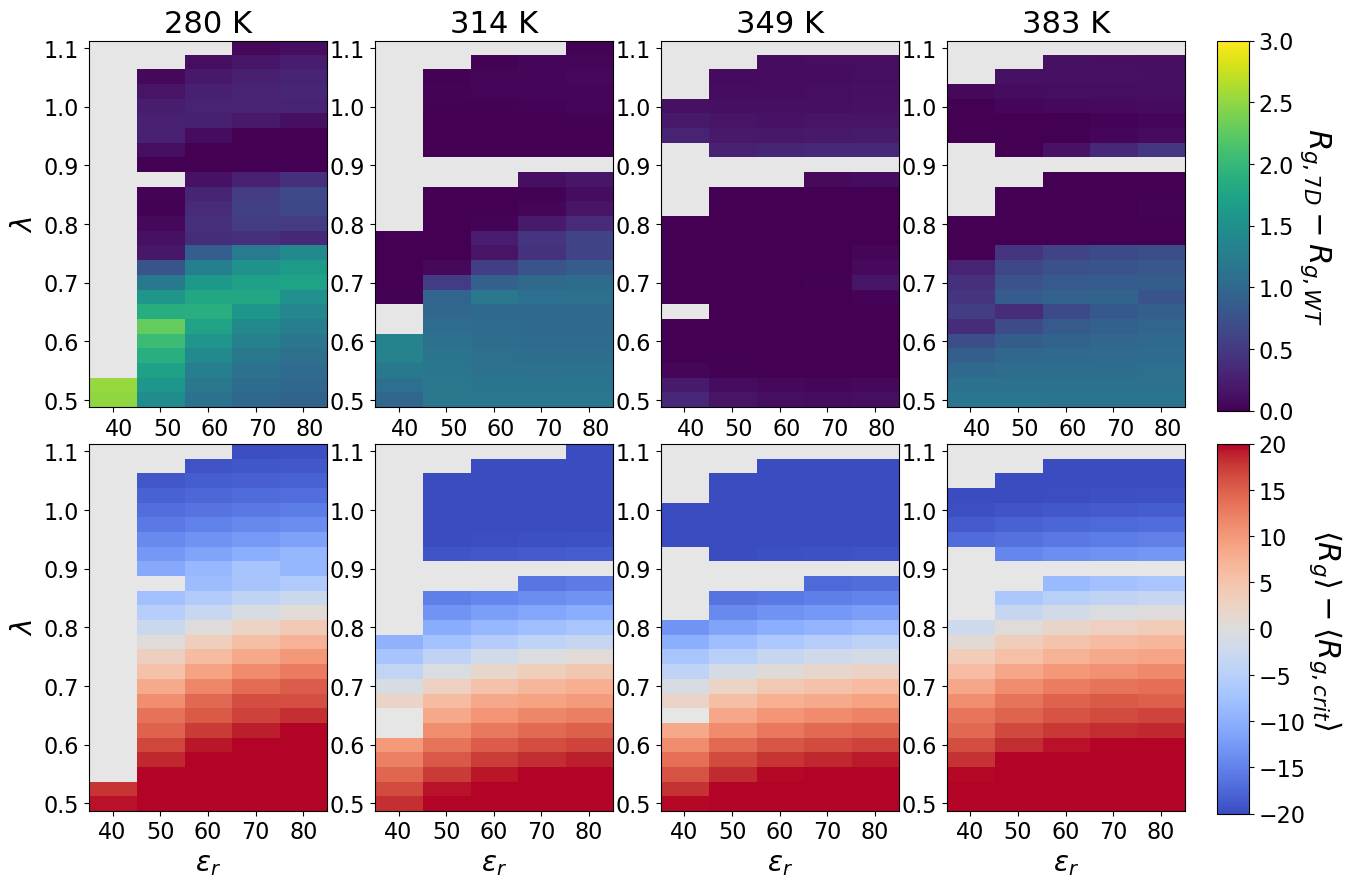

In [124]:
ts = np.linspace(280,400,8)
fig, axs = plt.subplots(2, 4, figsize=(16, 10))

for c, T in enumerate([0,2,4,6]):
    ls=["1.0", "0.8", "0.75", "0.6"]
    data = []
    for l in ls:
        if len(data) == 0:
            data = np.genfromtxt(f'/home/adria/scripts/md/bin/d7-wt/rw_{l}_HPST-{T}.txt', skip_header=2)
        else:
            test = np.genfromtxt(f'/home/adria/scripts/md/bin/d7-wt/rw_{l}_HPST-{T}.txt', skip_header=2)
            data = np.concatenate([data, test])

    ls = np.flip(np.unique(data[:,0]))
    eps = np.flip(np.unique(data[:,1]))
    
    rw = pd.DataFrame(index=eps, columns=ls)
    rw = rw.astype('float64')
    rgf = pd.DataFrame(index=eps, columns=ls)
    rgf = rw.astype('float64')
    neff_rw = pd.DataFrame(np.random.randint(0,10,size=(len(eps), len(ls))), index=eps, columns=ls)
    neff_rw = neff_rw.astype('float64')

    for row in data:
        l = row[0]
        e = row[1]
        diff = row[2]
        neff = row[3]
        neff = row[4]
        rgfr = (row[-1]+row[-2])/2-wt_rg_th
        if not np.isnan(rw[l][e]):
            if neff > neff_rw[l][e]:
                rw[l][e] = diff.astype(float)
                neff_rw[l][e] = neff 
                rgf[l][e] = rgfr
        else:
            rw[l][e] = diff.astype(float)
            neff_rw[l][e] = neff 
            rgf[l][e] = rgfr
    print(rw.values.max())
    cut = 0.1
    mask = rw
    mask.values[np.where(neff_rw.values<cut)] = np.nan
    
    mask2 = rgf
    mask2.values[np.where(neff_rw.values<cut)] = np.nan
    
    cmap = plt.get_cmap()
    cmap.set_bad(color = 'black', alpha = 0.1)
    
    centers = [eps.max(),eps.min(),ls.min(),ls.max()]
    dx, = np.diff(centers[:2])/(rw.T.values.shape[1]-1)
    dy, = -np.diff(centers[2:])/(rw.T.values.shape[0]-1) 
    extent = [centers[0]-dx/2, centers[1]+dx/2, centers[2]+dy/2, centers[3]-dy/2]

#     img_d = axs[0][c].pcolormesh(eps,ls,rw.T, cmap=cmap)
    img_d = axs[0][c].imshow(rw.T, cmap=cmap, aspect='auto', interpolation=None, extent=extent, vmin=0, vmax=3)
    axs[0][c].set_title(f"{ts[T]:.0f} K", fontsize=22)
    axs[0][c].tick_params(axis='both', which='major', labelsize=16)
    axs[0][c].invert_xaxis()
    axs[0][c].set_xticks(eps)
#     dx, = np.diff(centers[:2])/(X.shape[1]-1)
#     dy, = -np.diff(centers[2:])/(X.shape[0]-1)
    for label in axs[0][c].xaxis.get_majorticklabels():
        dx = 5/72.; dy = 0/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        label.set_transform(label.get_transform() + offset)
#     axs[0][c].set_yticks(ls[::2])
    
    cmap = plt.get_cmap('coolwarm')
    cmap.set_bad(color = 'black', alpha = 0.1)
#     img_c = axs[1][c].pcolormesh(eps,ls,rgf.T, cmap=cmap, vmin=-20, vmax=20)
    img_c = axs[1][c].imshow(rgf.T, cmap=cmap, aspect='auto', interpolation=None,  vmin=-20, vmax=20,  extent=extent)
    axs[1][c].set_xlabel("$\epsilon_r$", fontsize=20)
    axs[1][c].tick_params(axis='both', which='major', labelsize=16)
    axs[1][c].invert_xaxis()
    axs[1][c].set_xticks(eps)
#     axs[1][c].set_yticks(ls[::2])
    
axs[0][0].set_ylabel("$\lambda$", fontsize=20)  
axs[1][0].set_ylabel("$\lambda$", fontsize=20) 

fig.subplots_adjust(right=0.81)
cbar_ax = fig.add_axes([0.83, 0.51, 0.02, 0.37])
cbar1 = fig.colorbar(img_d, cax=cbar_ax)
cbar1.ax.tick_params(labelsize=16)
cbar1.set_label('$R_{g,7D}-R_{g,WT}$', rotation=270, fontsize=22, labelpad=28)


fig.subplots_adjust(right=0.81)
cbar_ax = fig.add_axes([0.83, 0.107, 0.02, 0.37])
cbar2 = fig.colorbar(img_c, cax=cbar_ax)
cbar2.ax.tick_params(labelsize=16)
cbar2.set_label('$\langle R_g⟩ - \langle R_{g,crit}⟩$', rotation=270, fontsize=22, labelpad=28)

fig.subplots_adjust(hspace=0.1)
# fig.tight_layout()

### WT - E4

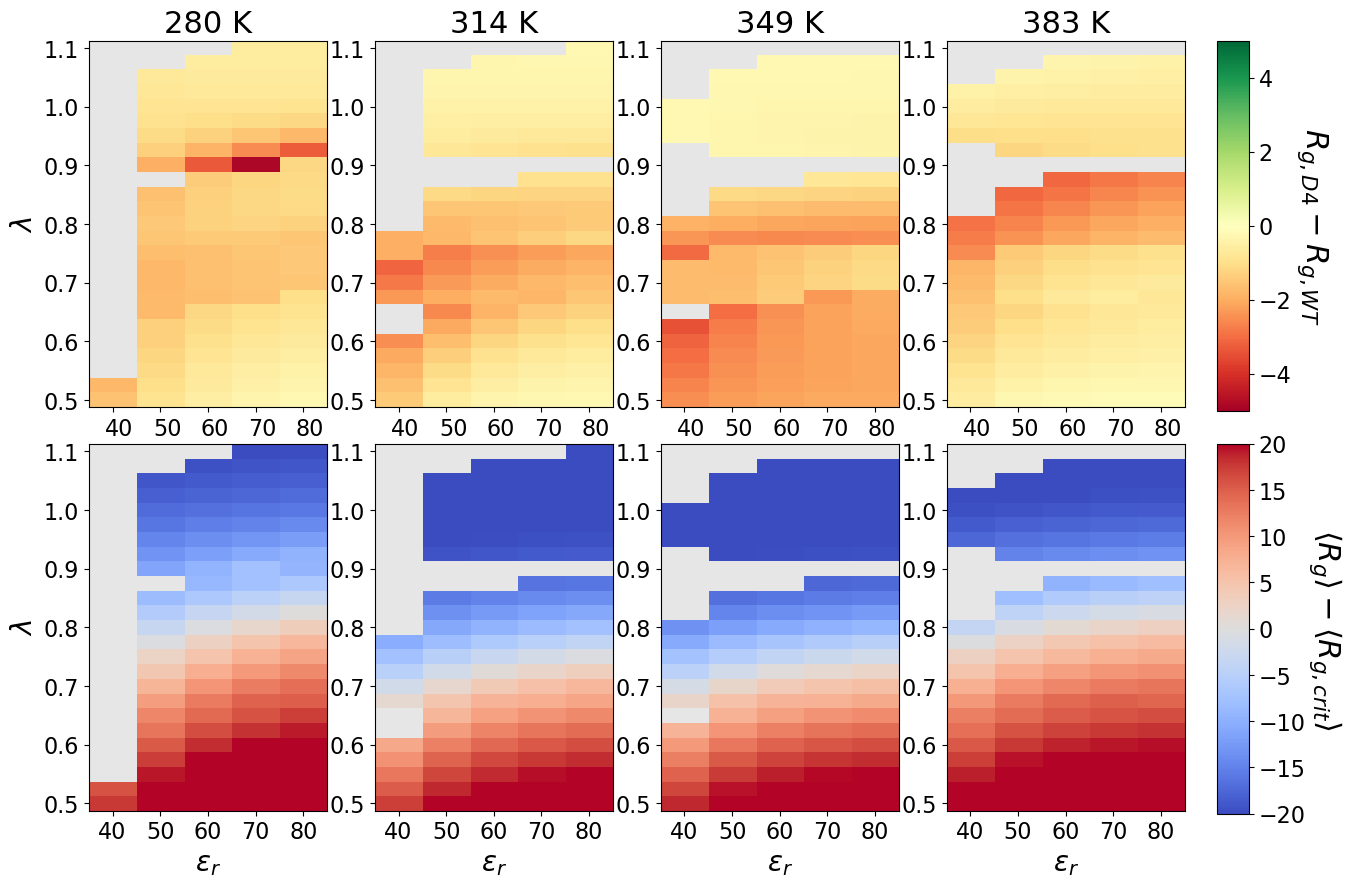

In [121]:
ts = np.linspace(280,400,8)
fig, axs = plt.subplots(2, 4, figsize=(16, 10))

for c, T in enumerate([0,2,4,6]):
    ls=["1.0", "0.8", "0.75", "0.6"]
    data = []
    for l in ls:
        if len(data) == 0:
            data = np.genfromtxt(f'/home/adria/scripts/md/bin/wt-d4/rw_{l}_HPST-{T}.txt', skip_header=2)
        else:
            test = np.genfromtxt(f'/home/adria/scripts/md/bin/wt-d4/rw_{l}_HPST-{T}.txt', skip_header=2)
            data = np.concatenate([data, test])

    ls = np.flip(np.unique(data[:,0]))
    eps = np.flip(np.unique(data[:,1]))
    
    rw = pd.DataFrame(index=eps, columns=ls)
    rw = rw.astype('float64')
    rgf = pd.DataFrame(index=eps, columns=ls)
    rgf = rw.astype('float64')
    neff_rw = pd.DataFrame(np.random.randint(0,10,size=(len(eps), len(ls))), index=eps, columns=ls)
    neff_rw = neff_rw.astype('float64')

    for row in data:
        l = row[0]
        e = row[1]
        diff = row[2]
        neff = row[3]
        neff = row[4]
        rgfr = (row[-1]+row[-2])/2-crit_rg
        if not np.isnan(rw[l][e]):
            if neff > neff_rw[l][e]:
                rw[l][e] = diff.astype(float)
                neff_rw[l][e] = neff 
                rgf[l][e] = rgfr
        else:
            rw[l][e] = diff.astype(float)
            neff_rw[l][e] = neff 
            rgf[l][e] = rgfr
    
    cut = 0.1
    mask = rw
    mask.values[np.where(neff_rw.values<cut)] = np.nan
    
    mask2 = rgf
    mask2.values[np.where(neff_rw.values<cut)] = np.nan
    
    cmap = plt.get_cmap('RdYlGn')
    cmap.set_bad(color = 'black', alpha = 0.1)
    
    centers = [eps.max(),eps.min(),ls.min(),ls.max()]
    dx, = np.diff(centers[:2])/(rw.T.values.shape[1]-1)
    dy, = -np.diff(centers[2:])/(rw.T.values.shape[0]-1) 
    extent = [centers[0]-dx/2, centers[1]+dx/2, centers[2]+dy/2, centers[3]-dy/2]

#     img_d = axs[0][c].pcolormesh(eps,ls,rw.T, cmap=cmap)
    img_d = axs[0][c].imshow(rw.T, cmap=cmap, aspect='auto', interpolation=None, extent=extent, vmin=-5, vmax=5)
    axs[0][c].set_title(f"{ts[T]:.0f} K", fontsize=22)
    axs[0][c].tick_params(axis='both', which='major', labelsize=16)
    axs[0][c].invert_xaxis()
    axs[0][c].set_xticks(eps)
#     dx, = np.diff(centers[:2])/(X.shape[1]-1)
#     dy, = -np.diff(centers[2:])/(X.shape[0]-1)
    for label in axs[0][c].xaxis.get_majorticklabels():
        dx = 5/72.; dy = 0/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        label.set_transform(label.get_transform() + offset)
#     axs[0][c].set_yticks(ls[::2])
    cmap = plt.get_cmap('coolwarm')
    cmap.set_bad(color = 'black', alpha = 0.1)
#     img_c = axs[1][c].pcolormesh(eps,ls,rgf.T, cmap=cmap, vmin=-20, vmax=20)
    img_c = axs[1][c].imshow(rgf.T, cmap=cmap, aspect='auto', interpolation=None,  vmin=-20, vmax=20,  extent=extent)
    axs[1][c].set_xlabel("$\epsilon_r$", fontsize=20)
    axs[1][c].tick_params(axis='both', which='major', labelsize=16)
    axs[1][c].invert_xaxis()
    axs[1][c].set_xticks(eps)
#     axs[1][c].set_yticks(ls[::2])
    
axs[0][0].set_ylabel("$\lambda$", fontsize=20)  
axs[1][0].set_ylabel("$\lambda$", fontsize=20) 

fig.subplots_adjust(right=0.81)
cbar_ax = fig.add_axes([0.83, 0.51, 0.02, 0.37])
cbar1 = fig.colorbar(img_d, cax=cbar_ax)
cbar1.ax.tick_params(labelsize=16)
cbar1.set_label('$R_{g,D4}-R_{g,WT}$', rotation=270, fontsize=22, labelpad=28)


fig.subplots_adjust(right=0.81)
cbar_ax = fig.add_axes([0.83, 0.107, 0.02, 0.37])
cbar2 = fig.colorbar(img_c, cax=cbar_ax)
cbar2.ax.tick_params(labelsize=16)
cbar2.set_label('$\langle R_g⟩ - \langle R_{g,crit}⟩$', rotation=270, fontsize=22, labelpad=28)

fig.subplots_adjust(hspace=0.1)
# fig.tight_layout()

### 0.75 eps only

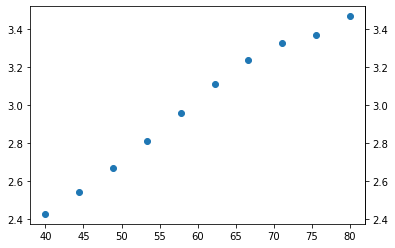

In [26]:
c=0
fig, ax = plt.subplots()
for T in range(0,1):
    ls=["0.75"]
    data = []
    for l in ls:
        if len(data) == 0:
            data = np.genfromtxt(f'/home/adria/rw_results_eps/rw_{l}_HPST-{T}.txt', skip_header=2)
        else:
            test = np.genfromtxt(f'/home/adria/rw_results_eps/rw_{l}_HPST-{T}.txt', skip_header=2)
            data = np.concatenate([data, test])
    ls = np.flip(np.unique(data[:,0]))
    eps = np.flip(np.unique(data[:,1]))
    ax.plot(np.flip(data[:,1]), data[:,2],'o')
    secaxy = ax.secondary_yaxis('right')
    secaxy.plot()

#     plt.plot(np.flip(data[:,1]), data[:,2],'o')
    
